<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/perceptive_bias_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs
Installs requirements and mounts file to Google Drive in order to save models.

In [ ]:
## Run once
!pip -q install import-ipynb
!pip -q install tensorflow==2.8
!apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

from google.colab import drive
drive.mount('/content/drive')

# check path
import os
print(os.getcwd())
print(os.listdir())

# cd your_path
%cd drive/MyDrive/Colab Notebooks/liasd

Reading package lists...
Building dependency tree...
Reading state information...
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/liasd
['perceptive_bias_model.ipynb', 'saved_models', 'explainers.ipynb', 'post_analysis.ipynb', 'utils.ipynb', 'colored_mnist.ipynb']
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/liasd'
/content/drive/MyDrive/Colab Notebooks/liasd


# Imports
Necessary imports, please note that when any imported .ipynb files are modified, you need to restart runtime (CTRL + M or Runtime > Restart Runtime) in order for changes to take effect.

In [ ]:
## Imports
import import_ipynb
import utils
import colored_mnist
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

SHAP's `DeepExplainer` does not support TensorFlow 2.0+ (namely eager-mode by default), while `Grad-CAM` requires it. Thus, we train the same model on two different versions of TensorFlow (1.x and 2.x behavior). However, the behavior of TensorFlow can only be changed at the beginning of a runtime. **In order to switch versions, you need to restart runtime**. 



In [ ]:
# ## TensorFlow version swapping (SHAP works with TF 1.x, GRAD-CAM with TF 2.x) 
tf1 = False
if tf1:
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

print('TensorFlow 2.x behavior ? ', tf.executing_eagerly())

TensorFlow 2.x behavior ?  True


# Parameters and load dataset

>> checking dataset regularity
label r / counts 421
label 9 / counts 514
label 8 / counts 478
label 7 / counts 579
label 6 / counts 512
label 5 / counts 443
label 4 / counts 555
label 3 / counts 520
label 2 / counts 488
label 1 / counts 575
label 0 / counts 515


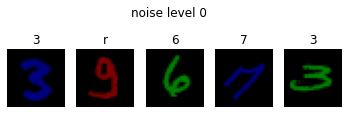

In [ ]:
## Parameters
num = 8000 # number of images to pull from original MNIST
split = (.7, .2, .1) # train/val/test split : (%train, %validation, %test) in 0 - 1 fraction
level = 0 # noise level (0-1)

## Fetch Colored-MNIST
# Colored-MNIST v.1. through v.3. : warning, v.3. is heavily biased (see report)
# bools = (False, False) # bools = (False, False) --> colored digits on black background (v1) ; bools = (True, False) --> colored digits, colored background (v2); bools = (True, True) --> colored digits, colored background, colored noise (v3. warning, this dataset is biased)
# (train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule) = colored_mnist.load_data(num, mnist_type='old', noise_level=level, bools=bools)

# Colored-MNIST v.4.
(train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule) = colored_mnist.load_data(num, noise_level=level, split=split)

# Model architecture and training

In [ ]:
## Models
# Color-biased model
color_model = keras.Sequential()
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_ims[0].shape, name='conv1'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
color_model.add(keras.layers.Flatten())
color_model.add(keras.layers.Dense(13, activation=tf.keras.activations.softmax))

input_shape = train_ims.shape
color_model.build(input_shape)

color_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# color_model.summary()

print('>> Color-biased model training')
color_model.fit(train_ims, train_color, batch_size=12, epochs=5, shuffle=True)

>> Color-biased model training
Epoch 1/5
467/467 [==============================] - 2s 4ms/step - loss: 0.0257 - accuracy: 0.9959
Epoch 2/5
467/467 [==============================] - 2s 4ms/step - loss: 3.8956e-09 - accuracy: 1.0000
Epoch 3/5
467/467 [==============================] - 3s 6ms/step - loss: 1.0005e-09 - accuracy: 1.0000
Epoch 4/5
467/467 [==============================] - 3s 6ms/step - loss: 5.3218e-10 - accuracy: 1.0000
Epoch 5/5
467/467 [==============================] - 3s 6ms/step - loss: 3.1931e-10 - accuracy: 1.0000


In [ ]:
# Shape-biased model
shape_model = keras.Sequential()
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_ims[0].shape, name='conv1'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
shape_model.add(keras.layers.Flatten())
shape_model.add(keras.layers.Dense(13, activation=tf.keras.activations.softmax))

input_shape = train_ims.shape
shape_model.build(input_shape)

shape_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# shape_model.summary()

print('>> Shape-biased model training')
shape_model.fit(train_ims, train_shape, batch_size=12, epochs=15, shuffle=True)

>> Shape-biased model training
Epoch 1/15
467/467 [==============================] - 2s 4ms/step - loss: 0.5124 - accuracy: 0.8427
Epoch 2/15
467/467 [==============================] - 2s 4ms/step - loss: 0.1722 - accuracy: 0.9523
Epoch 3/15
467/467 [==============================] - 2s 4ms/step - loss: 0.1196 - accuracy: 0.9666
Epoch 4/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0874 - accuracy: 0.9755
Epoch 5/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0684 - accuracy: 0.9804
Epoch 6/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0578 - accuracy: 0.9850
Epoch 7/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0470 - accuracy: 0.9857
Epoch 8/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0387 - accuracy: 0.9880
Epoch 9/15
467/467 [==============================] - 2s 4ms/step - loss: 0.0315 - accuracy: 0.9920
Epoch 10/15
467/467 [==============================] - 2s 4ms/step - 

In [ ]:
# Rule-biased model
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_ims[0].shape, name='conv1'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(13, activation=tf.keras.activations.softmax))

input_shape = train_ims.shape
model.build(input_shape)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

print('>> Rule-biased model training')
model.fit(train_ims, train_rule, batch_size=12, epochs=25, shuffle=True)

>> Rule-biased model training
Epoch 1/25
467/467 [==============================] - 2s 4ms/step - loss: 0.4984 - accuracy: 0.8462
Epoch 2/25
467/467 [==============================] - 2s 4ms/step - loss: 0.1728 - accuracy: 0.9514
Epoch 3/25
467/467 [==============================] - 2s 4ms/step - loss: 0.1173 - accuracy: 0.9698
Epoch 4/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0831 - accuracy: 0.9732
Epoch 5/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0720 - accuracy: 0.9793
Epoch 6/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0538 - accuracy: 0.9846
Epoch 7/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0455 - accuracy: 0.9871
Epoch 8/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0387 - accuracy: 0.9911
Epoch 9/25
467/467 [==============================] - 2s 4ms/step - loss: 0.0328 - accuracy: 0.9904
Epoch 10/25
467/467 [==============================] - 2s 4ms/step - l

In [ ]:
# Rule-biased model 2 : VGG-16 architecture
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

input_shape = train_ims[0].shape

model = Sequential()
model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='conv2'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=13, activation="softmax"))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

print('>> VGG16 Rule-biased model training')
model.fit(train_ims, train_rule, batch_size=12, epochs=25, shuffle=True)

>> VGG16 Rule-biased model training
Epoch 1/25
467/467 [==============================] - 17s 33ms/step - loss: 2.9682 - accuracy: 0.1037
Epoch 2/25
467/467 [==============================] - 16s 33ms/step - loss: 2.3978 - accuracy: 0.0962
Epoch 3/25
467/467 [==============================] - 16s 33ms/step - loss: 2.3964 - accuracy: 0.0968
Epoch 4/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3959 - accuracy: 0.0945
Epoch 5/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3954 - accuracy: 0.1023
Epoch 6/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3951 - accuracy: 0.1009
Epoch 7/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3950 - accuracy: 0.1014
Epoch 8/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3948 - accuracy: 0.1048
Epoch 9/25
467/467 [==============================] - 16s 34ms/step - loss: 2.3948 - accuracy: 0.1007
Epoch 10/25
467/467 [=========================

# Save
Saves models in tf1 or tf2 directories depending on the TensorFlow version that was used.

In [ ]:
## Save models
# get corresponding path
color_path = utils.pathfinder(tf1, level, 'color')
shape_path = utils.pathfinder(tf1, level, 'shape')
rule_path = utils.pathfinder(tf1, level, 'rule')

# save to path and overwrite if necessary
color_model.save(color_path, overwrite=True)
shape_model.save(shape_path, overwrite=True)
model.save(rule_path, overwrite=True)

In [ ]:
print(rule_path)

/content/drive/MyDrive/Colab Notebooks/liasd/saved_models/tf2/rule_biased0
